# 시계열 중간 대체 과제

- 통계학과 201822032 조윤호

In [25]:
library('tidyverse')
library('forecast')
library('lmtest')# dwtest
library('TTR')# SMA
library('data.table')
library('gridExtra')

In [2]:
stationery <- scan("stationery(1).txt")
data1 <- read.csv("data1(1).csv")
usapass <- scan("usapass(2).txt")

## 1

### 1)

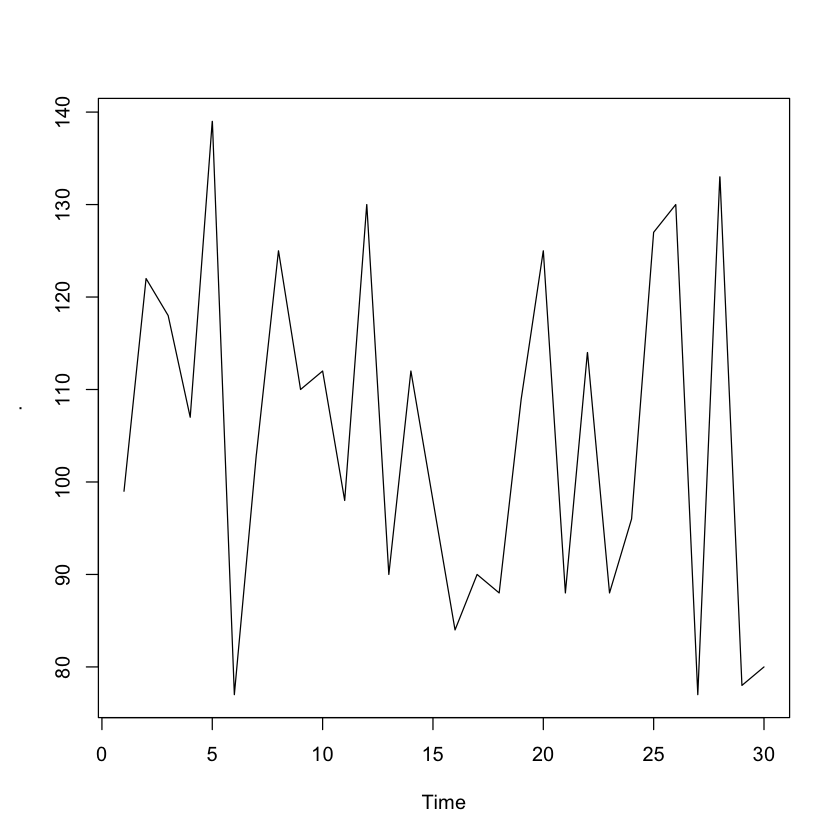

In [3]:
ts(stationery) %>% plot

In [4]:
stat.df <- tibble(
    t = 1:length(stationery),
    zt = ts(stationery))

- 추세 없어 보임.  
분산이 커지는 느낌도 없음.  
30일간이라 주기성을 따지기도 애매.  

- 딱 보기에는 불규칙성분만 가지고 있는 상수평균모형으로 보인다.  
$z_t = \beta_0 + \epsilon_t$

혹시 모르니 선형 추세 정도 시도해본다.

In [5]:
reg <- lm(zt ~ t, data = stat.df)
summary(reg)


Call:
lm(formula = zt ~ t, data = stat.df)

Residuals:
    Min      1Q  Median      3Q     Max 
-32.493 -14.225  -4.125  11.825  34.143 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 112.3931     6.9084  16.269 8.42e-16 ***
t            -0.4834     0.3891  -1.242    0.224    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.45 on 28 degrees of freedom
Multiple R-squared:  0.05224,	Adjusted R-squared:  0.01839 
F-statistic: 1.543 on 1 and 28 DF,  p-value: 0.2244


- $R^2$ = 0.05부터 너무 낮다.

Warning message:
“Ignoring unknown parameters: geom”
Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.



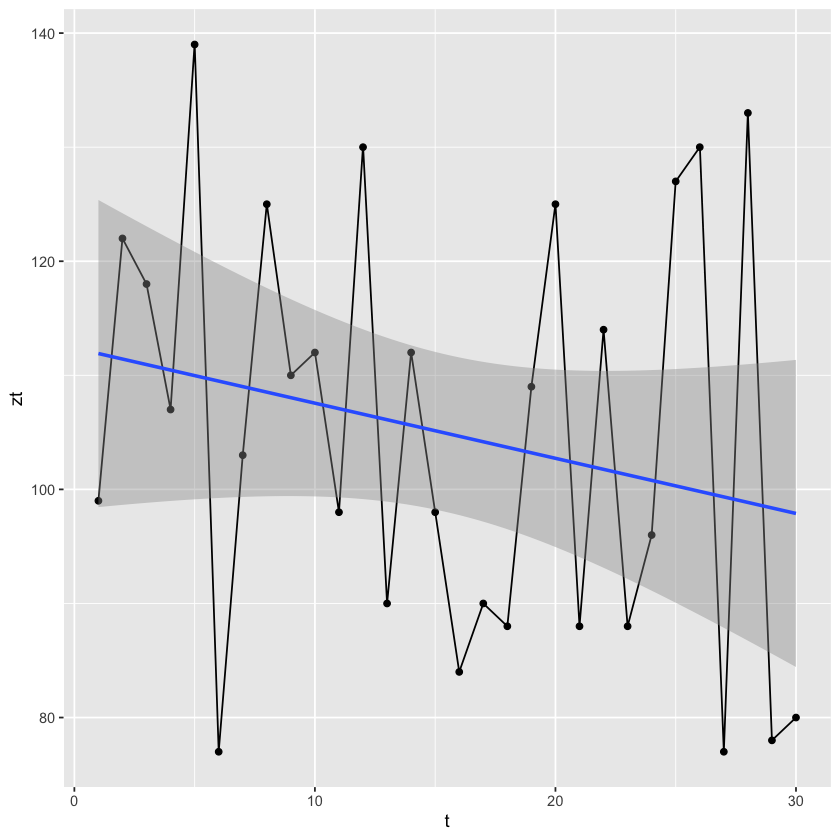

In [6]:
ggplot(data = stat.df, aes(t, zt)) +
geom_point() + 
geom_line() + 
geom_smooth(method = "lm",
              formula = y ~ x,
              geom = "smooth")

말이 안되는 오차 범위.

In [7]:
stat.df %>% mutate(exp_zt = mean(stat.df$zt)) %>% mutate(err = zt - exp_zt) -> stat.df
stat.df %>% head

t,zt,exp_zt,err
<int>,<dbl>,<dbl>,<dbl>
1,99,104.9,-5.9
2,122,104.9,17.1
3,118,104.9,13.1
4,107,104.9,2.1
5,139,104.9,34.1
6,77,104.9,-27.9


- 눈에 쉽게 보이지 않는 것일지도 모르니 평활법 사용

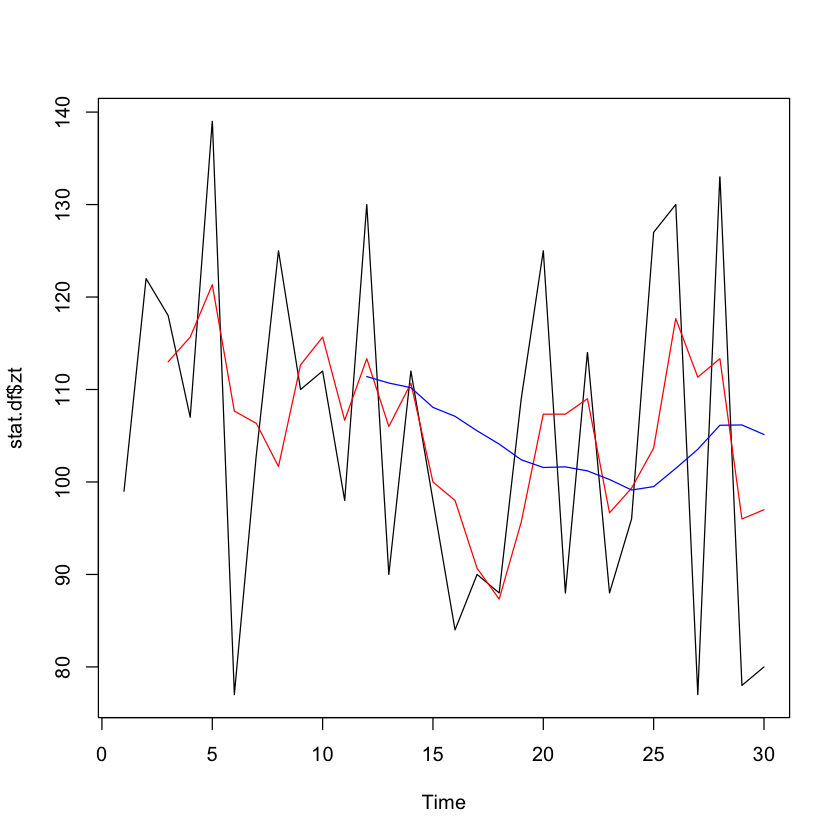

In [8]:
stat.SMA3 <- SMA(stat.df$zt, n = 3)
plot.ts(stat.df$zt)
lines(stat.SMA3, col = 'red', lty = 1)
lines(SMA(stat.SMA3, n = 10), col = 'blue', lty = 1)

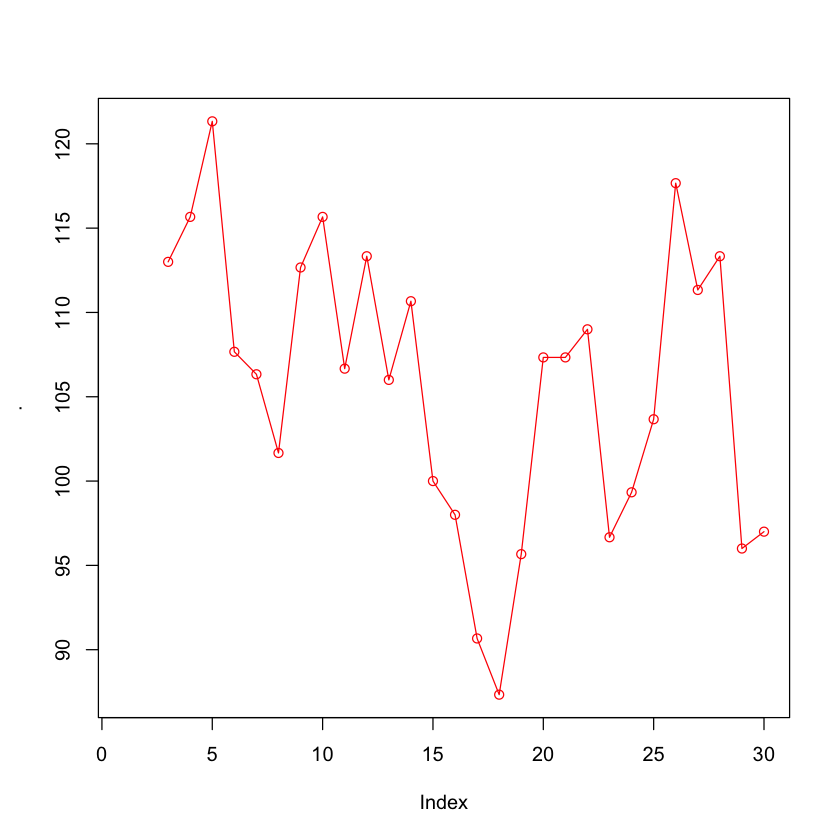

In [9]:
stat.SMA3 %>% plot(type = 'o', col = 'red')

- 원 데이터와 별 차이 없음.  
window 10을 주기는 데이터 수가 30개로 작다고 판단.

### 2)

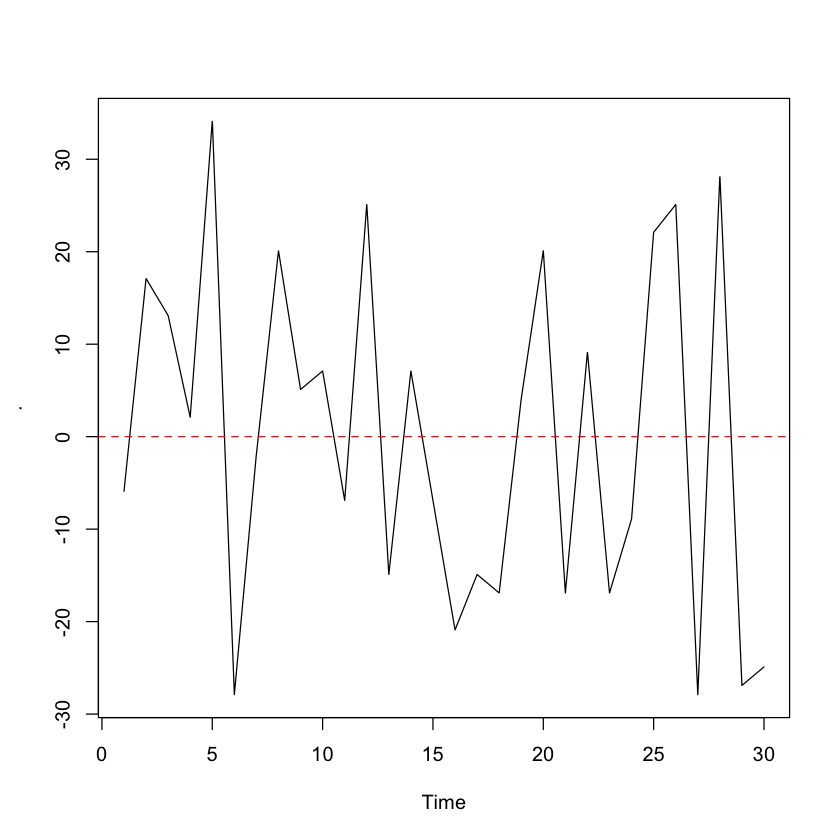

In [10]:
stat.df$err %>% plot
abline(h = 0, col = 'red', lty = 2)

In [11]:
lm(data = stat.df, zt ~ 1) -> reg1
reg1 %>% summary


Call:
lm(formula = zt ~ 1, data = stat.df)

Residuals:
   Min     1Q Median     3Q    Max 
 -27.9  -16.4    0.1   16.1   34.1 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)    104.9        3.4   30.86   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 18.62 on 29 degrees of freedom


In [12]:
dwtest(reg1)


	Durbin-Watson test

data:  reg1
DW = 2.3954, p-value = 0.8654
alternative hypothesis: true autocorrelation is greater than 0


- durbin-watson결과 2에 근접하게 나와 문제 없어 보인다.  
다만, p-value는 유의수준에 못미치긴한다.

### 3)

- 상수 평균 모형의 예측값은 결국 평균값.  
고로 모두 104.9

## 2

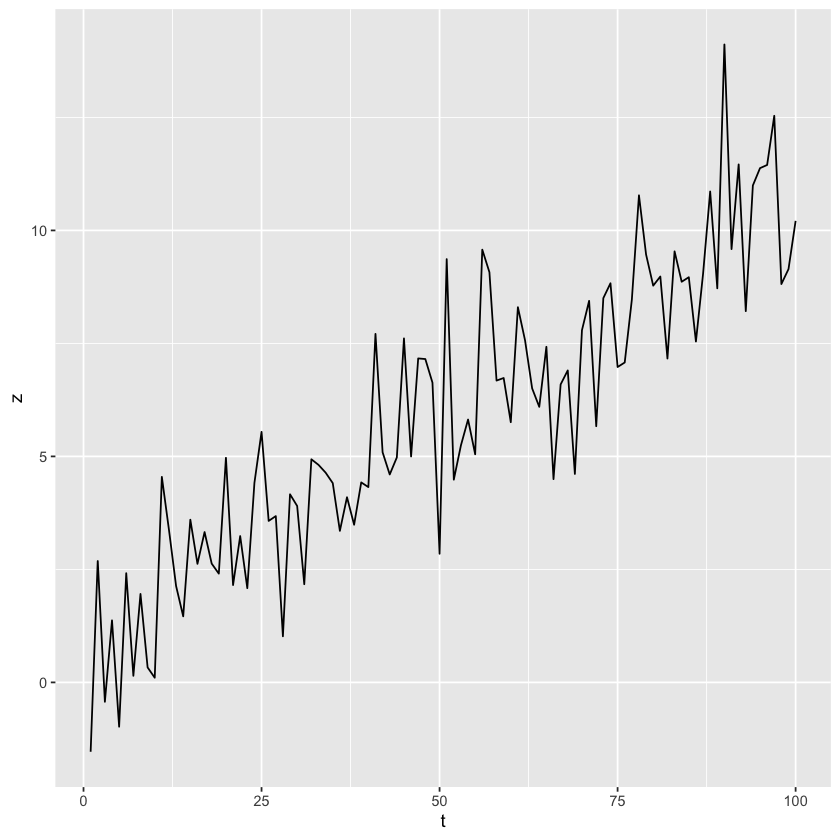

In [13]:
ggplot(data = data1, aes(t, z)) +
geom_line()

### 1)

- 추세는 그냥 봐도 보이고  
분산이 증가하는지는 잔차를 살펴보아야할 것 같다. 일단 겉보기에는 그렇지 않아보임.    
일단 선형추세 전제로 모델 적합한 뒤 잔차를 확인해서 불규칙적인 특성이 보인다면,  
주기성이 있다고 생각해서 계절모형까지 추가하면 될 것으로 보인다.

In [14]:
data1 %>% head

,X,t,z
,<int>,<int>,<dbl>
1,1,1,-1.5346871
2,2,2,2.6850469
3,3,3,-0.4288189
4,4,4,1.3724199
5,5,5,-0.9800884
6,6,6,2.4156505


In [15]:
lm(data = data1, z ~ t) -> reg2.1
reg2.1 %>% summary


Call:
lm(formula = z ~ t, data = data1)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.0803 -1.0287  0.0169  0.8426  4.3288 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.818932   0.296301   2.764  0.00682 ** 
t           0.099619   0.005094  19.557  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.47 on 98 degrees of freedom
Multiple R-squared:  0.796,	Adjusted R-squared:  0.7939 
F-statistic: 382.5 on 1 and 98 DF,  p-value: < 2.2e-16


Warning message:
“Ignoring unknown parameters: geom”


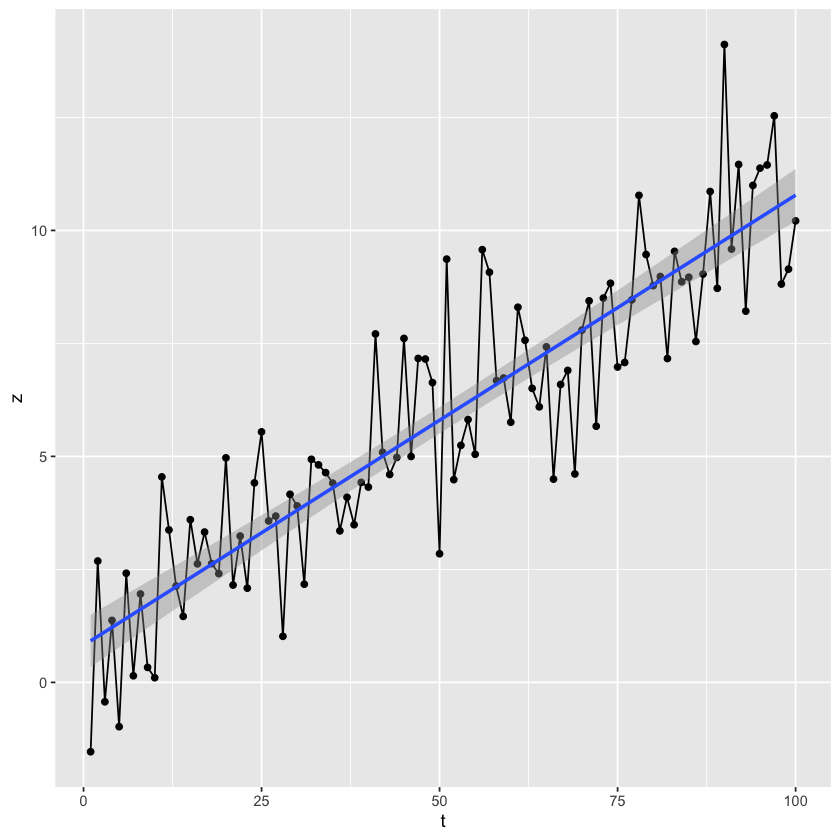

In [16]:
ggplot(data = data1, aes(t, z)) +
geom_point() + 
geom_line() + 
geom_smooth(method = "lm",
              formula = y ~ x,
              geom = "smooth")

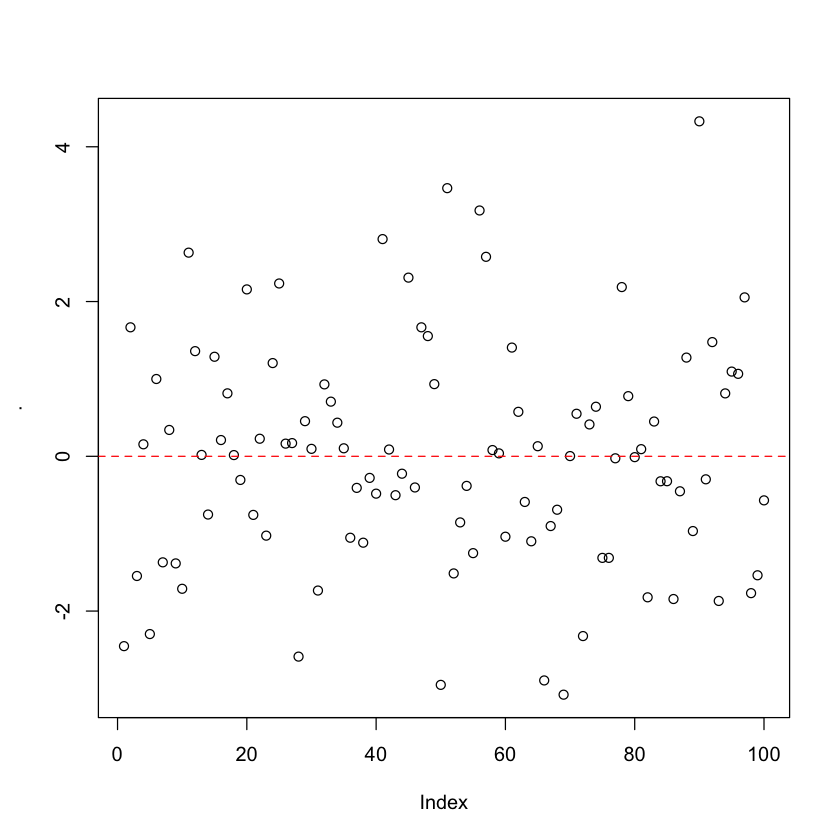

In [17]:
reg2.1$residuals %>% plot()
abline(h = 0, col = 'red', lty = 2)

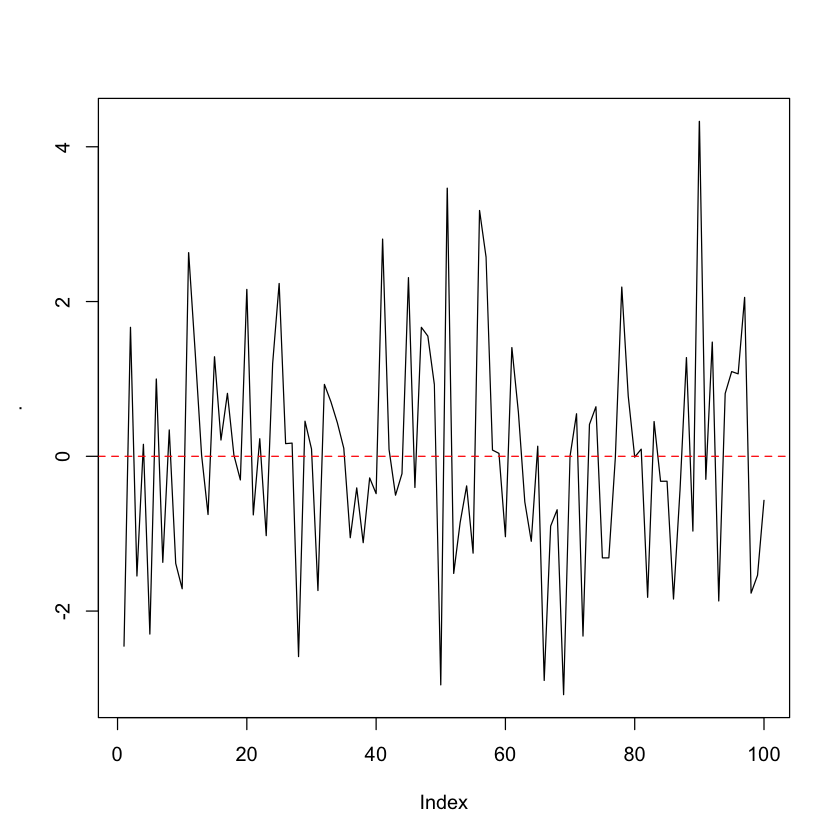

In [18]:
reg2.1$residuals %>% plot(type = 'l')
abline(h = 0, col = 'red', lty = 2)

In [19]:
reg2.1 %>% dwtest()


	Durbin-Watson test

data:  .
DW = 2.2164, p-value = 0.8389
alternative hypothesis: true autocorrelation is greater than 0


- trend만 가진 선형추세모형이 맞는 거 같다.

[1] -0.12315065  0.01897738  0.08077064

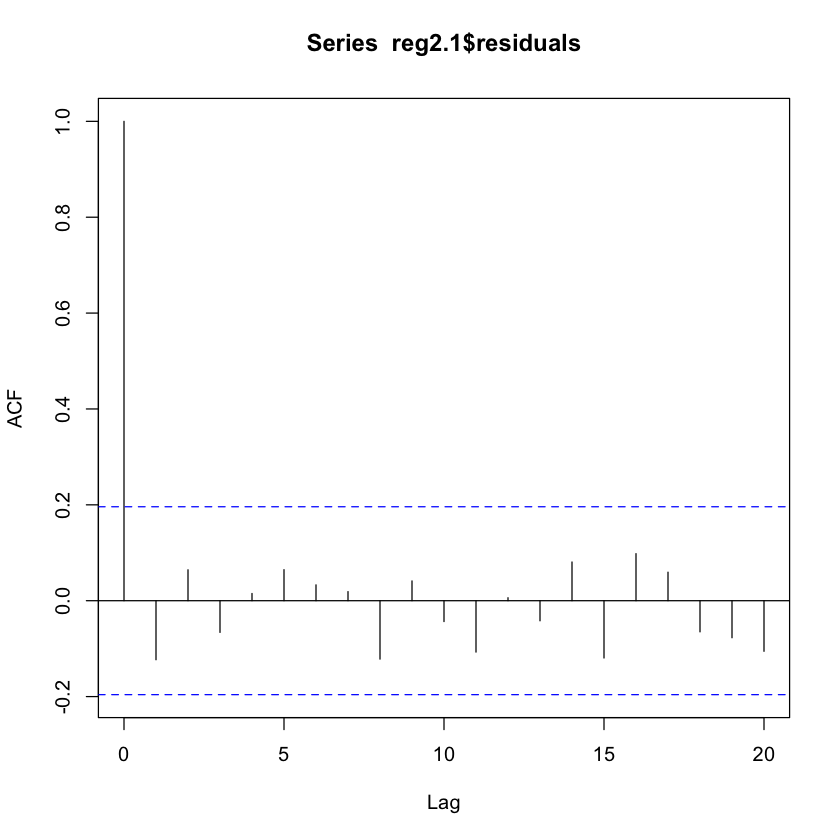

In [20]:
acf(reg2.1$residuals)$acf[c(2,8,15)]

- 뭔가 유의수준이내라 의미있다고 하기는 그러지만 lag 1, lag 8, lag 15 가 같은 길이만큼 막대기가 내려온것 같다.  
마침 간격이 7로 동일한데 7의 경우 일주일을 의미하는 경우도 가능하기에 아주 엄밀히 말하면 주기의 가능성이 0이라고만은 말하기 어려울지도 모른다.  
하지만 종합적인 근거로 볼 때 선형모형이 더 적합하다고 생각할 경우의 수가 더 높다고 본다.

### 2)

In [21]:
predict(reg2.1, newdata = tibble(t = 101:110)) %>% round(2)

1     2     3     4     5     6     7     8     9    10 
10.88 10.98 11.08 11.18 11.28 11.38 11.48 11.58 11.68 11.78

### 3)

- 선형추세 사용할거라 holt사용

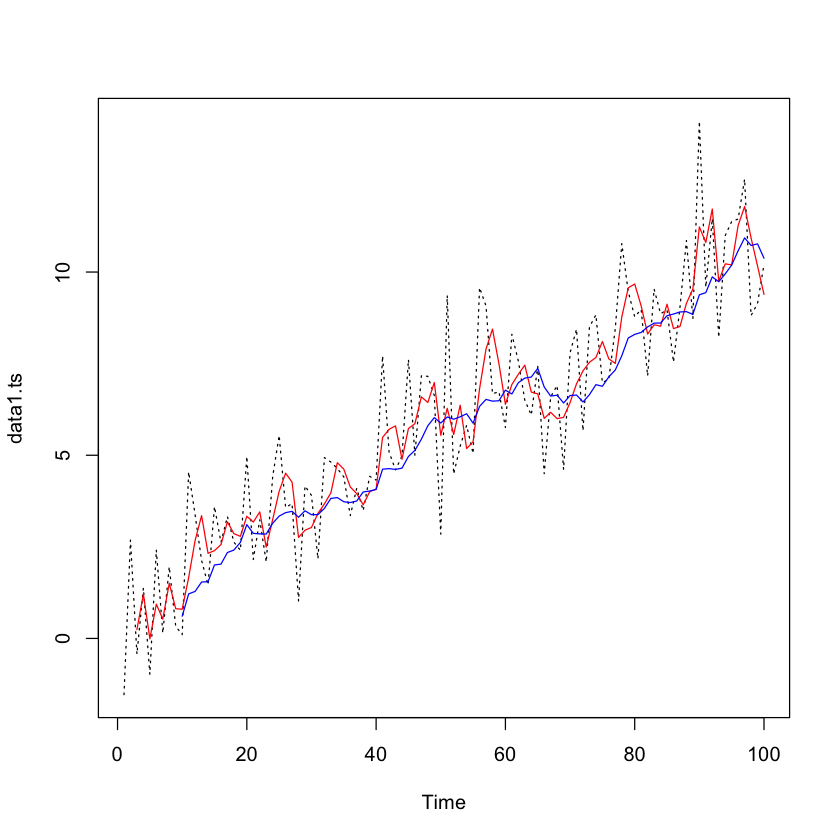

In [55]:
data1.SMA3 <- SMA(data1.ts, n = 3)
data1.SMA10 <- SMA(data1.ts, n = 10)
plot.ts(data1.ts, lty = 3)
lines(data1.SMA3, col = 'red', lty = 1)
lines(data1.SMA10, col = 'blue', lty = 1) 

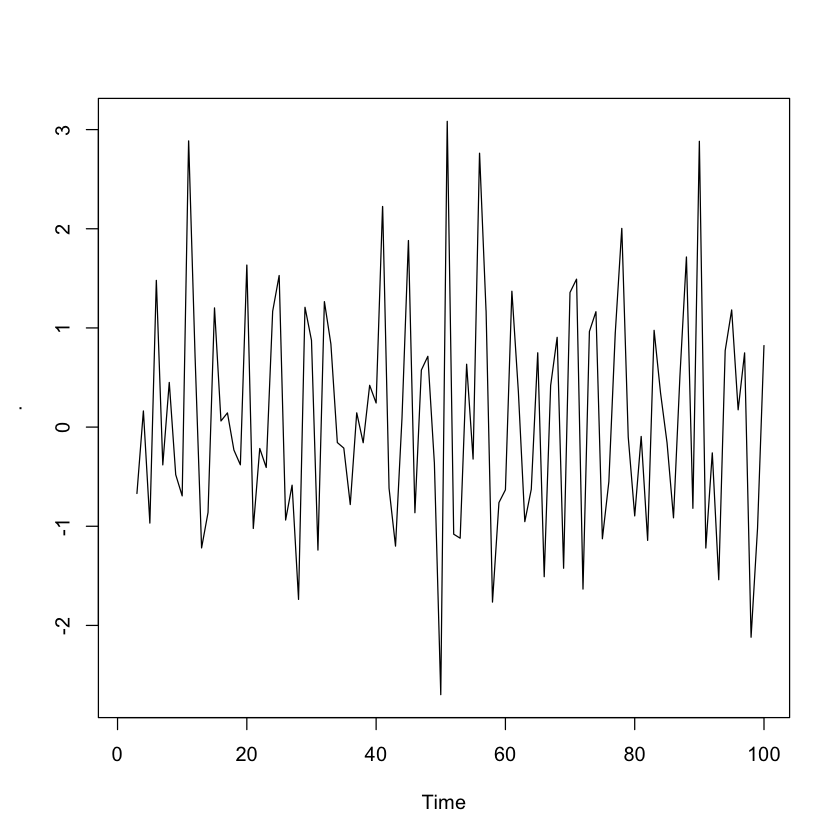

In [58]:
(data1.ts - data1.SMA3) %>% plot

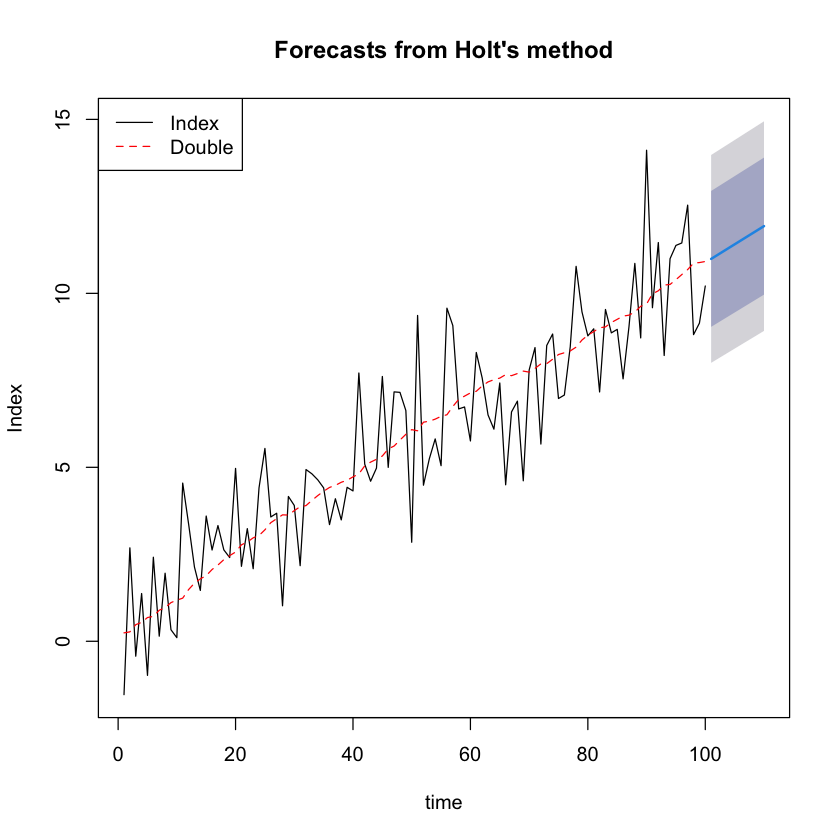

In [91]:
fit2.3b <- holt(data1$z, h= 10) 

plot(fit2.3b, ylab = "Index", xlab = "time",  lty = 1, col = "black")
lines(fitted(fit2.3b), col="red", lty=2)
legend("topleft", lty=1:2, col=c("black","red"), c("Index", "Double"))

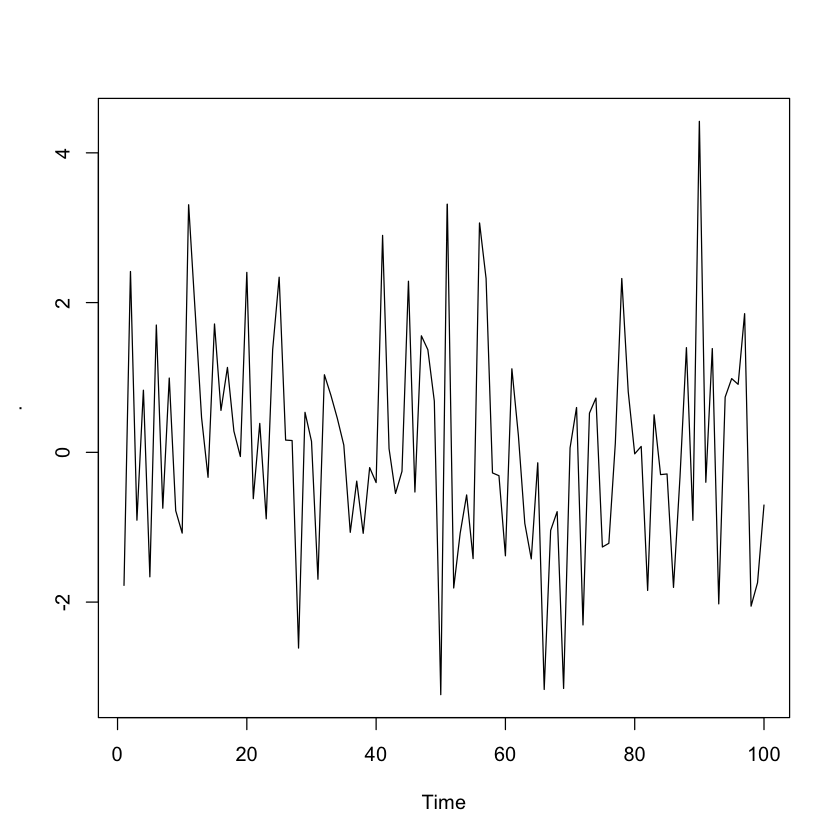

In [107]:
fit2.3b$residuals %>% plot

- 검정통계량 D

In [128]:
sum((fit2.3b$residuals[2:100] - fit2.3b$residuals[1:99])^2)/sum(fit2.3b$residuals^2)

[1] 2.199587

잔차의 분포나 durbinwatson검정통계량이나 문제 없어보인다.

### 4) 예측값

In [135]:
fit2.3b[2]

$mean
Time Series:
Start = 101 
End = 110 
Frequency = 1 
 [1] 10.99007 11.09479 11.19952 11.30424 11.40897 11.51369 11.61842 11.72314
 [9] 11.82787 11.93259

In [139]:
data1.new <- read.csv("data1_new(1).csv")
data1.new

X,t,z
<int>,<int>,<dbl>
1,101,11.577471
2,102,13.171004
3,103,12.730258
4,104,12.242375
5,105,10.877077
6,106,13.297355
7,107,14.632224
8,108,15.049088
9,109,9.671734


- predict 2) MSE

In [147]:
(predict(reg2.1, newdata = tibble(t = 101:110)) - data1.new$z)^2 %>% mean

[1] 3.919789

In [179]:
t(tibble(fore = fit2.3b[2]))

fore,"10.99007, 11.09479, 11.19952, 11.30424, 11.40897, 11.51369, 11.61842, 11.72314, 11.82787, 11.93259"


In [181]:
predict2.4 = c(10.99007, 11.09479, 11.19952, 11.30424, 11.40897, 11.51369, 11.61842, 11.72314, 11.82787, 11.93259)

- predict 4) MSE

In [182]:
(predict2.4 - data1.new$z)^2 %>% mean

[1] 3.621776

- 결론 : holt의 MSE가 단순추세모형보다 더 낮게 나타나는 것으로 보아 더 우수한 것으로 보인다.

## 3

### 1)

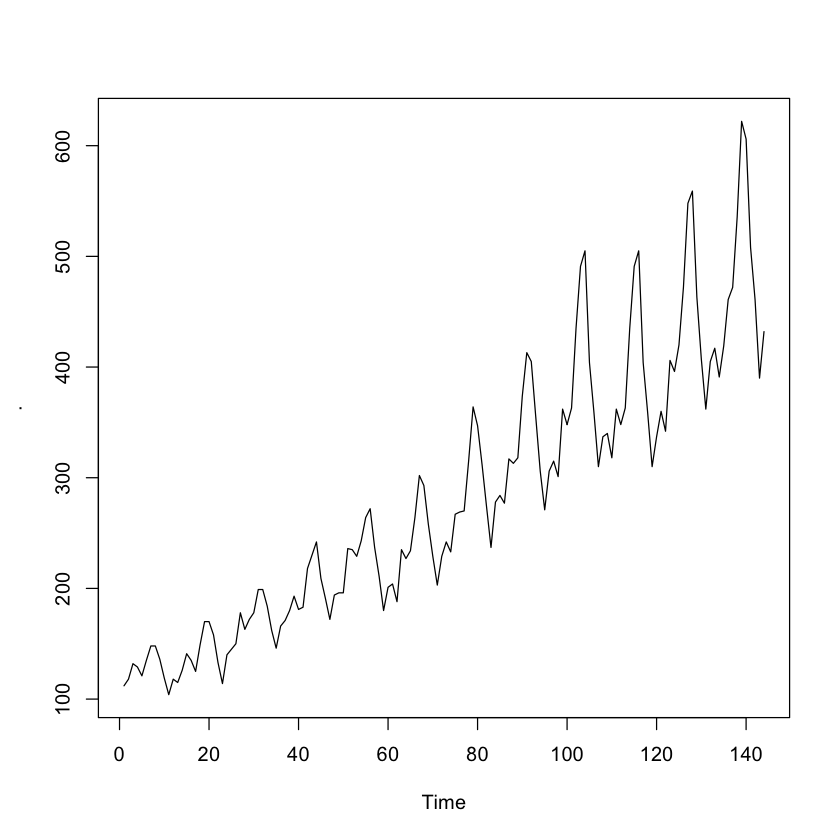

In [184]:
ts(usapass) %>% plot

시간이 지남에 따라 분산이 늘어가는게 보인다. 따라서 이분산성을 해결하기 위해 log변환이 필요함.

### 2)

추세, 계절성 모두 볼 수 있음  
이분산성도 보이므로 승법모형 사용해도 되지만 그냥 로그변환이후 가법모형사용

$Z_t =  T_t + S_t + I_t$

- 쉬운 이해를 위해 연도도 삽입

In [224]:
log_usa <- log(ts(usapass, start = c(2000, 1), frequency = 12))
t <- 1:length(log_usa)

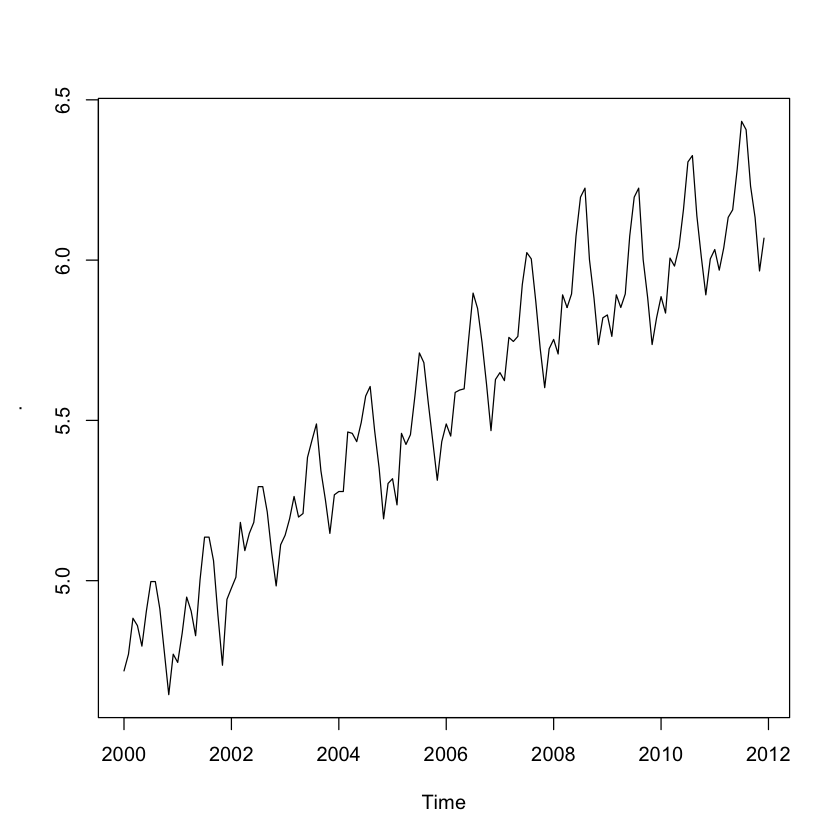

In [225]:
log_usa %>% plot

In [226]:
fit3.1 <- lm(log_usa ~ t)
fit3.1 %>% summary


Call:
lm(formula = log_usa ~ t)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30875 -0.10481 -0.01736  0.09677  0.36311 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 4.8131072  0.0237011  203.07   <2e-16 ***
t           0.0100802  0.0002836   35.54   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1415 on 142 degrees of freedom
Multiple R-squared:  0.899,	Adjusted R-squared:  0.8982 
F-statistic:  1263 on 1 and 142 DF,  p-value: < 2.2e-16


- 추세만 추출

In [227]:
trend <- fitted(fit3.1)

- 추세성분을 구했으니 원래데이터에서 추세성분을 빼준다.  
그러면 계절성분과 불규칙성분만 남음.  
거기서 계절성분까지 빼주려면 계절성분도 구해야한다.

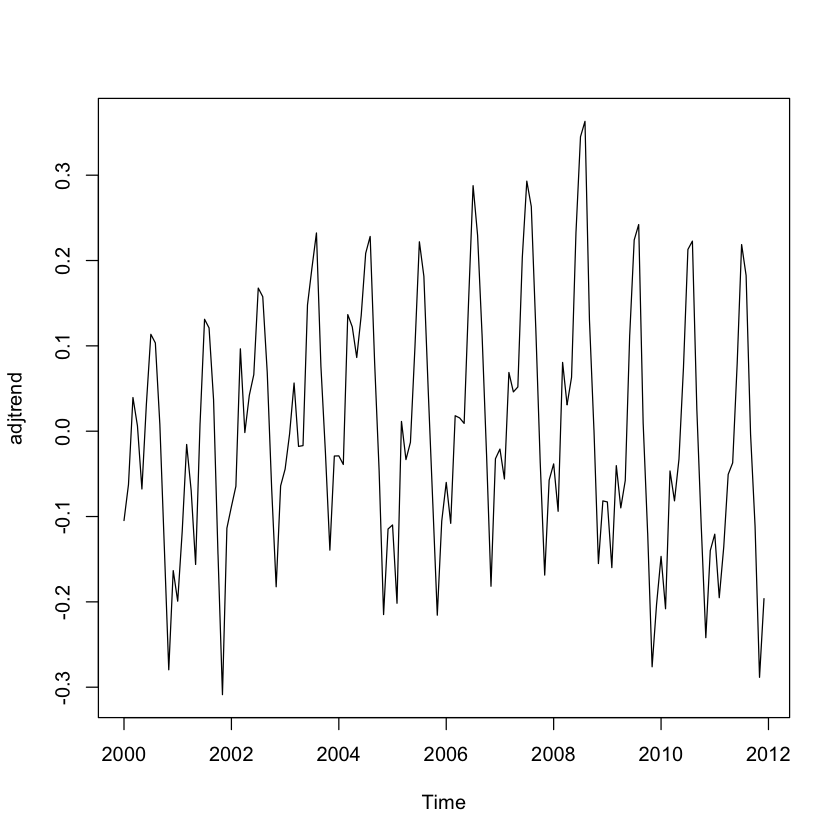

In [228]:
adjtrend = log_usa - trend
plot.ts(adjtrend)

In [229]:
y = factor(cycle(adjtrend))
fit3.2 <- lm(adjtrend ~ 0 + y)
summary(fit3.2)


Call:
lm(formula = adjtrend ~ 0 + y)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.158515 -0.044012  0.001096  0.045041  0.152437 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
y1  -0.08709    0.01790  -4.865 3.20e-06 ***
y2  -0.10916    0.01790  -6.098 1.11e-08 ***
y3   0.02245    0.01790   1.254  0.21195    
y4  -0.01022    0.01790  -0.571  0.56899    
y5  -0.01075    0.01790  -0.600  0.54926    
y6   0.11206    0.01790   6.260 5.00e-09 ***
y7   0.21799    0.01790  12.178  < 2e-16 ***
y8   0.21067    0.01790  11.769  < 2e-16 ***
y9   0.05919    0.01790   3.306  0.00122 ** 
y10 -0.07583    0.01790  -4.236 4.24e-05 ***
y11 -0.22103    0.01790 -12.348  < 2e-16 ***
y12 -0.10829    0.01790  -6.049 1.40e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.06201 on 132 degrees of freedom
Multiple R-squared:  0.8214,	Adjusted R-squared:  0.8052 
F-statistic: 50.59 on 12 and 132 DF,  p-value: < 2.2e-16


In [230]:
seasonal <- fitted(fit3.2)

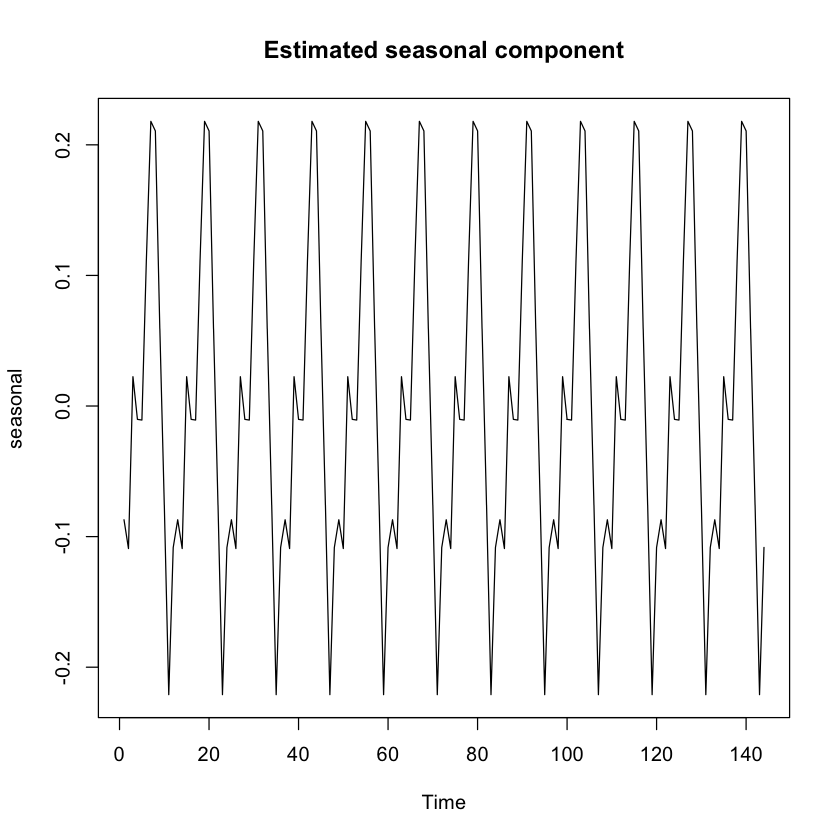

In [231]:
ts.plot(seasonal, main = "Estimated seasonal component")

In [233]:
pred <- trend + seasonal

- trend는 단순선형을 사용해서 구했고, seasoanl은 지시함수를 사용해서 구했음.

In [234]:
irregular <- log_usa - pred

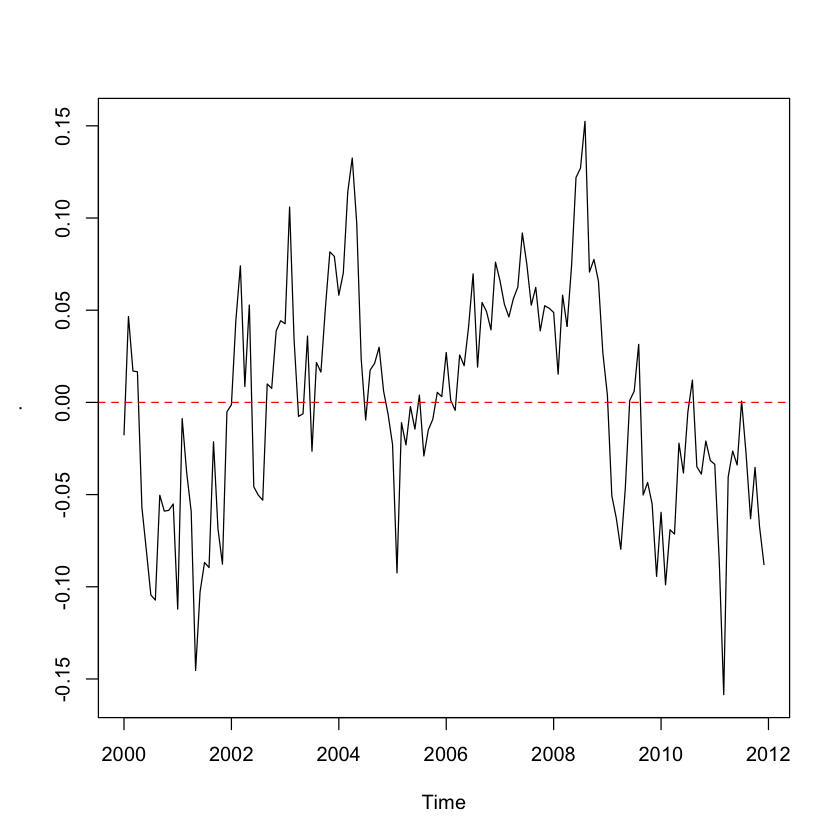

In [242]:
irregular %>% plot
abline(h = 0, col = 'red', lty = 2)

- 1차 양의 자기상관이 보임.

In [239]:
dwtest(lm(irregular ~ 1), alternative = 'two.sided')


	Durbin-Watson test

data:  lm(irregular ~ 1)
DW = 0.40817, p-value < 2.2e-16
alternative hypothesis: true autocorrelation is not 0


- 결과가 좋지 않다.

### 3)

In [277]:
fit3.3 = hw(ts(usapass, start = c(2000, 1), frequency = 12), seasonal = "multiplicative", h = 12) # 1년 예측이라 12
fit3.3$model

Holt-Winters' multiplicative method 

Call:
 hw(y = ts(usapass, start = c(2000, 1), frequency = 12), h = 12,  

 Call:
     seasonal = "multiplicative") 

  Smoothing parameters:
    alpha = 0.3421 
    beta  = 0.0111 
    gamma = 0.6404 

  Initial states:
    l = 121.3568 
    b = 0.366 
    s = 0.9426 0.8295 0.9117 1.0395 1.1459 1.1572
           1.0387 0.9221 1.0273 1.0837 0.9757 0.926

  sigma:  0.044

     AIC     AICc      BIC 
1427.850 1432.707 1478.337 

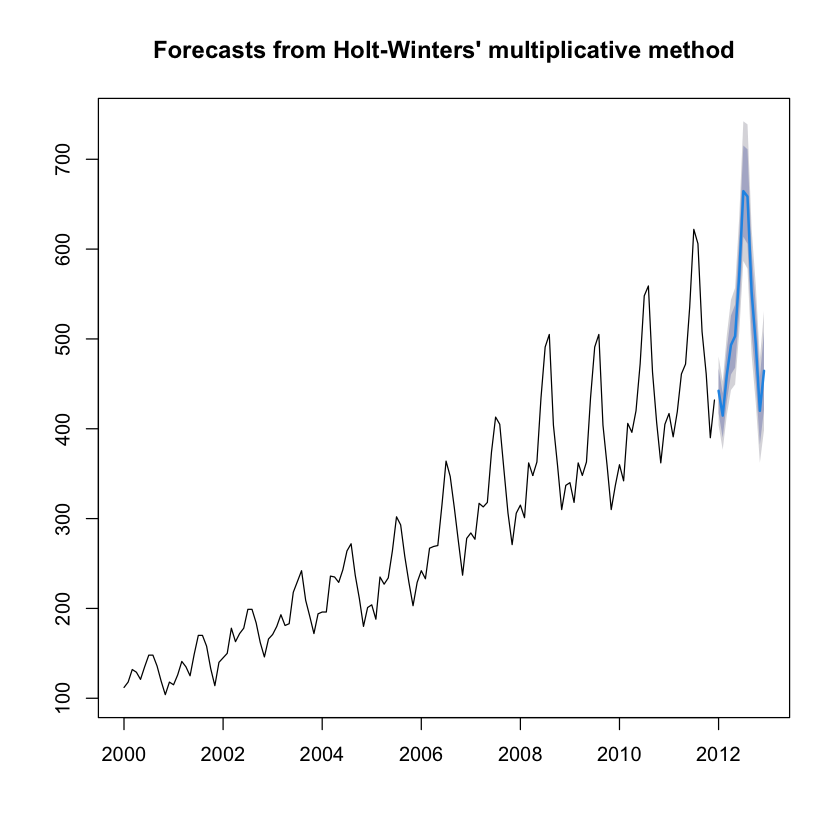

In [278]:
fit3.3 %>% plot

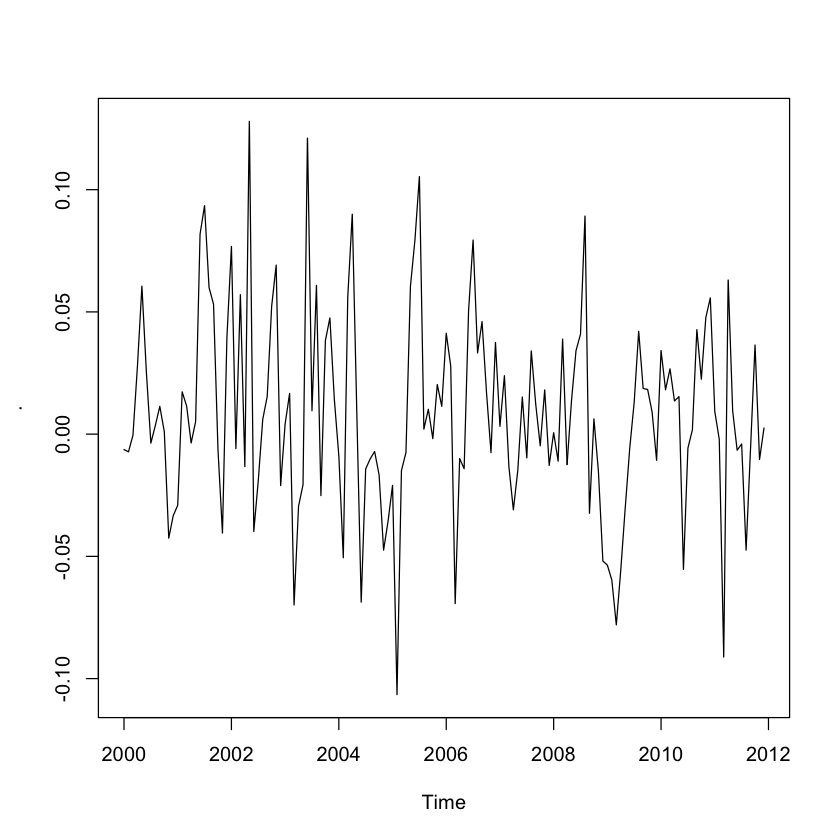

In [280]:
fit3.3$residuals %>% plot

In [282]:
dwtest(lm(fit3.3$residuals ~ 1), alternative = 'two.sided')


	Durbin-Watson test

data:  lm(fit3.3$residuals ~ 1)
DW = 1.4608, p-value = 0.001122
alternative hypothesis: true autocorrelation is not 0


### 4)

In [285]:
dec_fit2.4 <- decompose(ts(usapass, start = c(2000, 1), frequency = 12), type = "multiplicative")

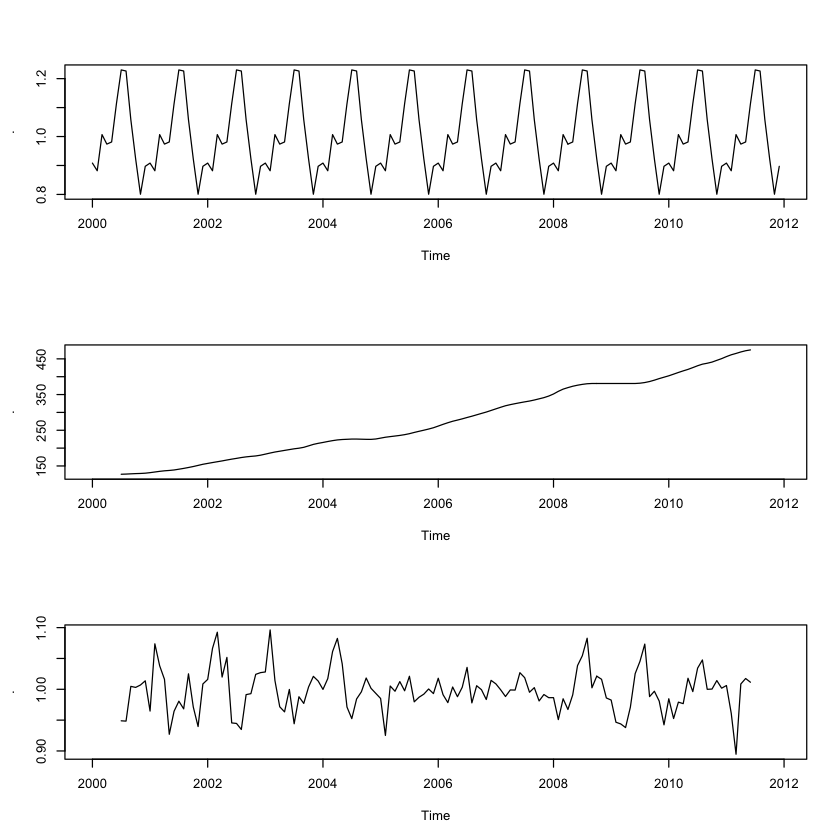

In [380]:
par(mfrow = c(3,1))
dec_fit2.4$seasonal %>% plot
dec_fit2.4$trend %>% plot
dec_fit2.4$random %>% plot

In [289]:
stl_fit3.4 <- stl(log_usa, s.window = 12)
stl_fit3.4$time.series %>% head

,seasonal,trend,remainder
Jan 2000,-0.0908934374,4.816290,-0.00689733
Feb 2000,-0.0841946511,4.819998,0.03488157
Mar 2000,0.0482262974,4.823706,0.01086984
Apr 2000,0.0009225527,4.827414,0.03147600
May 2000,-0.0168433127,4.831614,-0.01898027
Jun 2000,0.0958679056,4.835814,-0.02640753


In [296]:
stl_fit_result <- stl_fit3.4$time.series

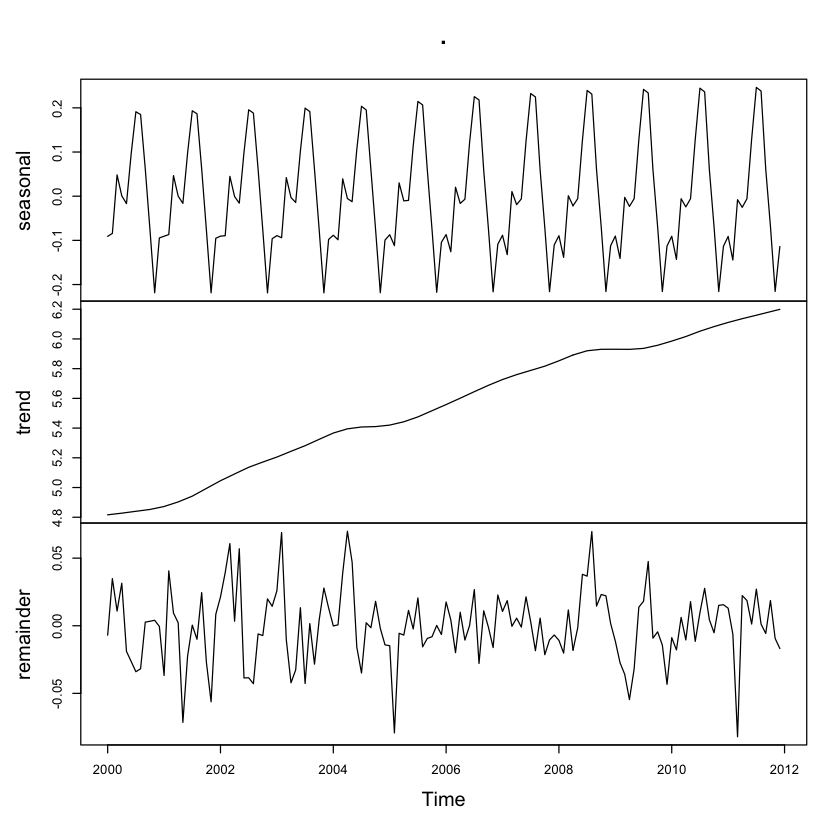

In [307]:
stl_fit_result %>% plot

- 적절하다.

## 4

### 1)

In [350]:
set.seed(2022)
et <- rnorm(100)
et2 <- rnorm(1000)

In [355]:
z = rep(0,101)
for(i in 1:100){
    z[1] = 5
    z[i+1] = 5 + 0.8*z[i] + et[i]
    }

In [358]:
z = z[2:101]

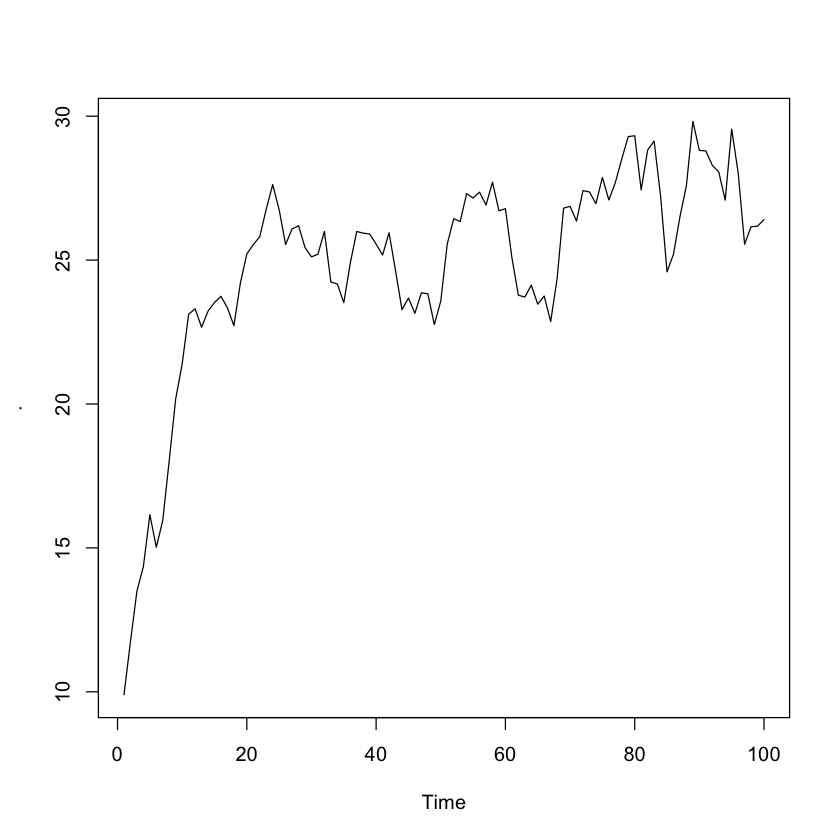

In [359]:
ts(z) %>% plot

### 2)

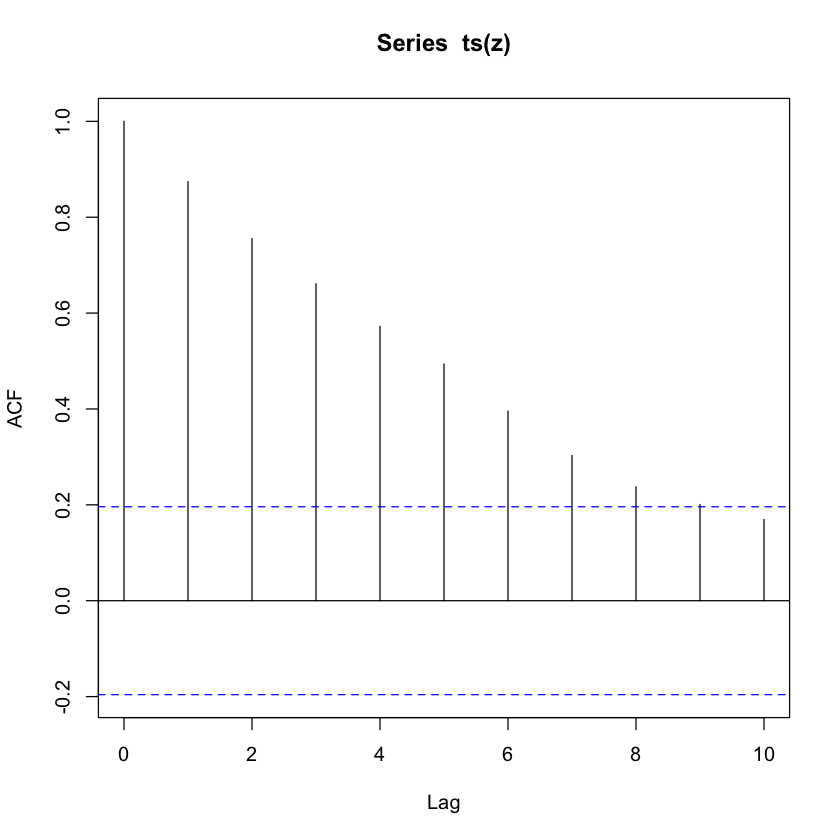

In [360]:
acf(ts(z), lag = 10)

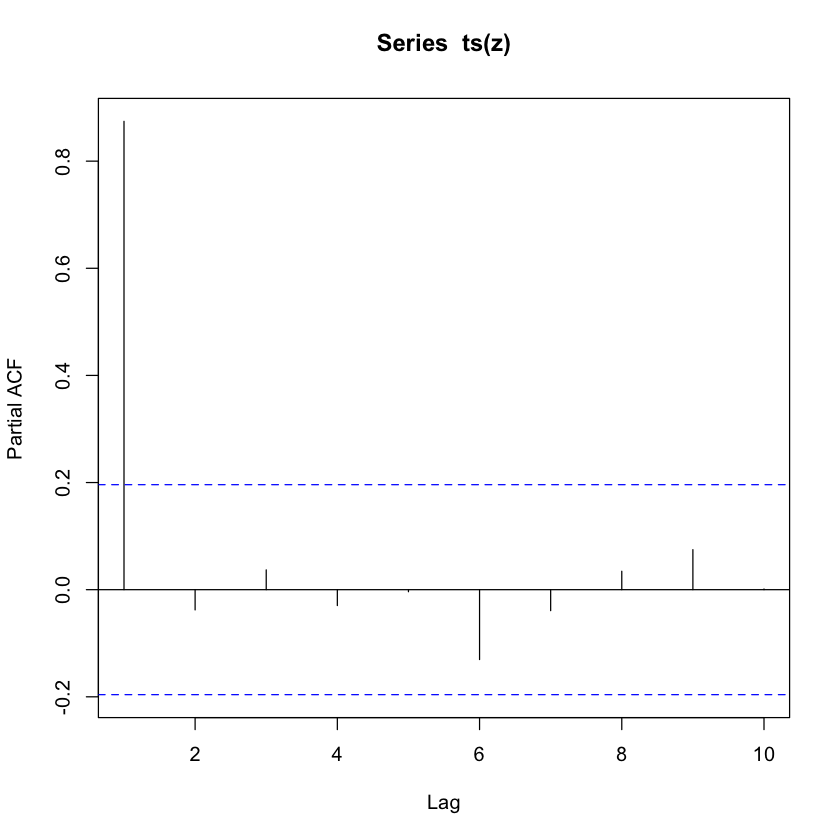

In [361]:
pacf(ts(z), lag = 10)

### 3)

### 4)

In [362]:
z2 = rep(0,1001)
for(i in 1:1000){
    z2[1] = 5
    z2[i+1] = 5 + 0.8*z2[i] + et2[i]
    }

In [363]:
z2 = z2[2:1001]

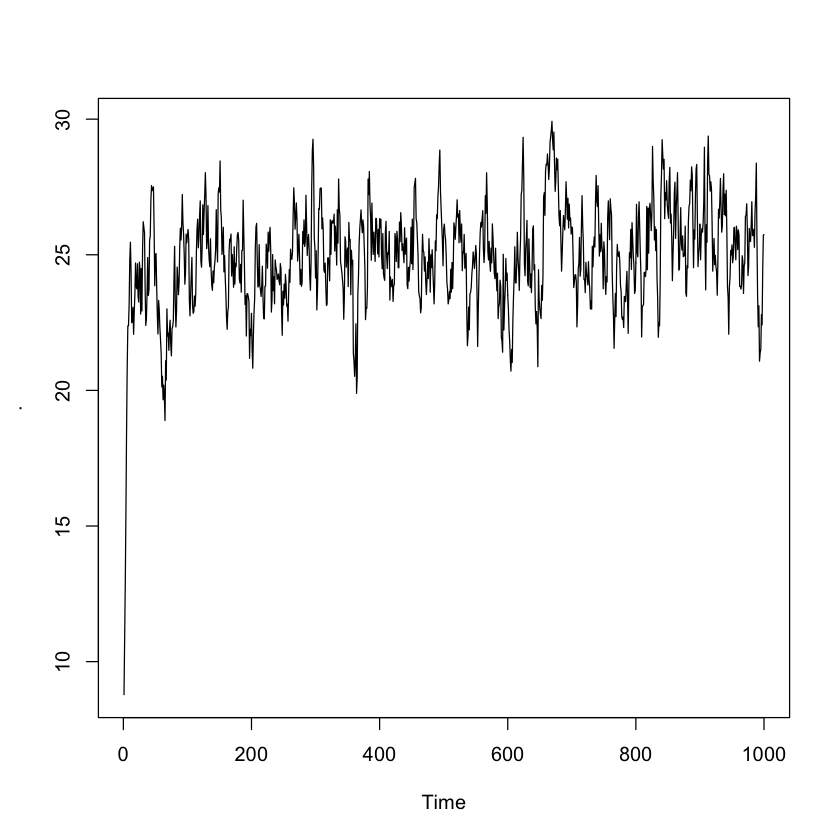

In [366]:
ts(z2) %>% plot

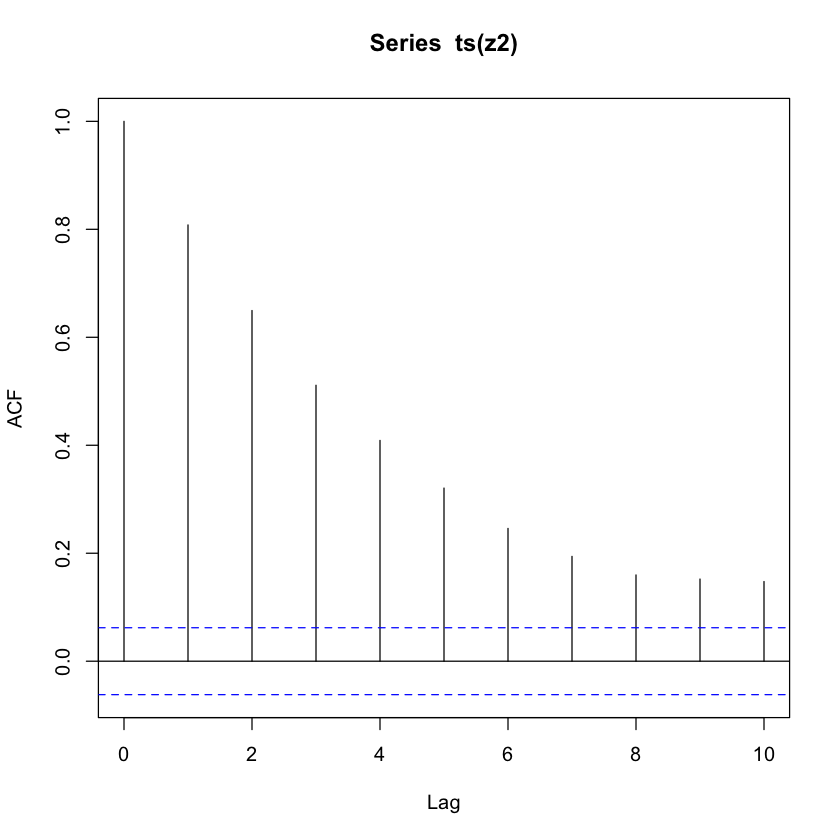

In [369]:
acf(ts(z2),lag = 10)

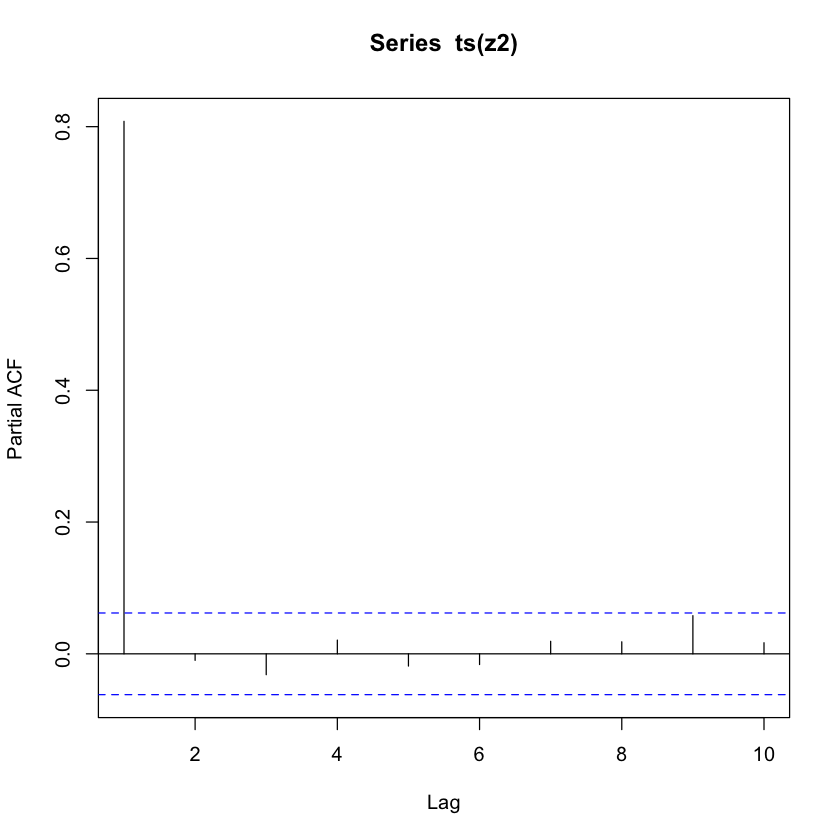

In [370]:
pacf(ts(z2), lag = 10)

- 비교하기

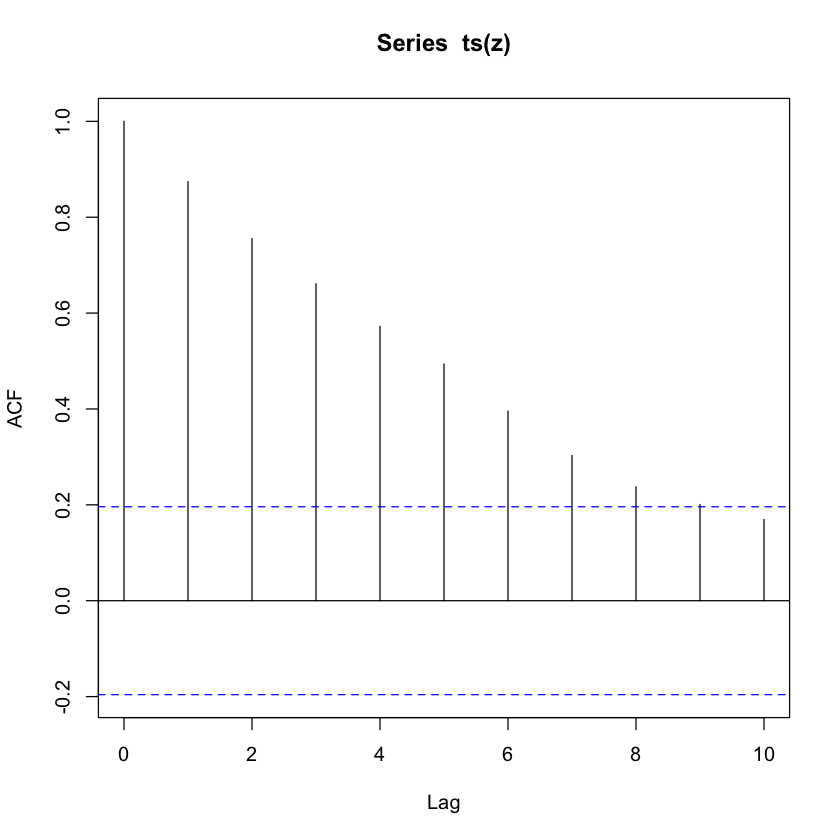

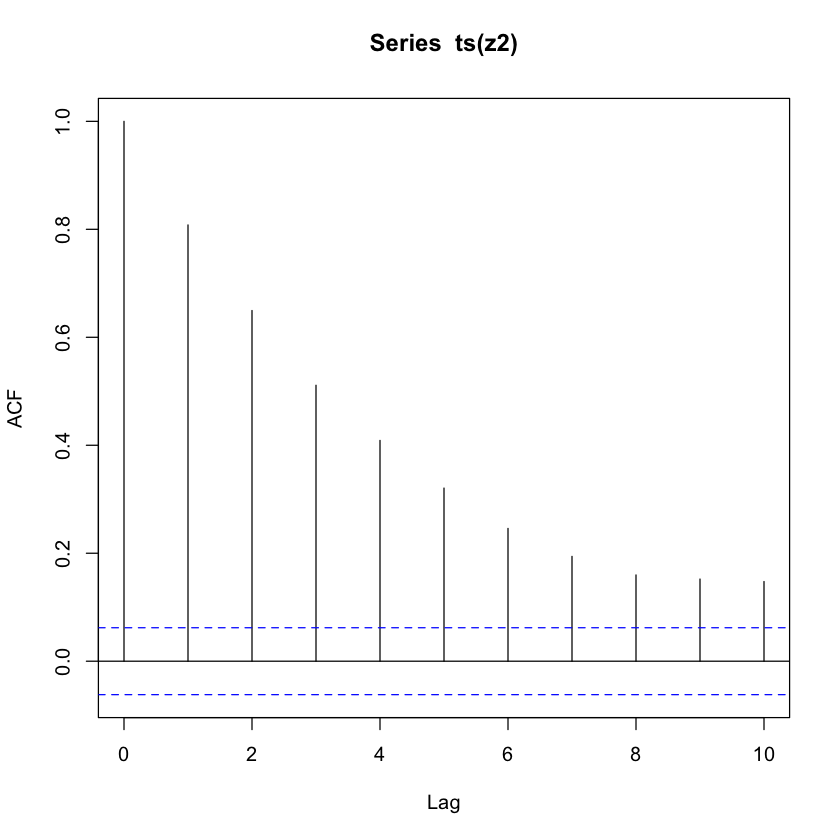

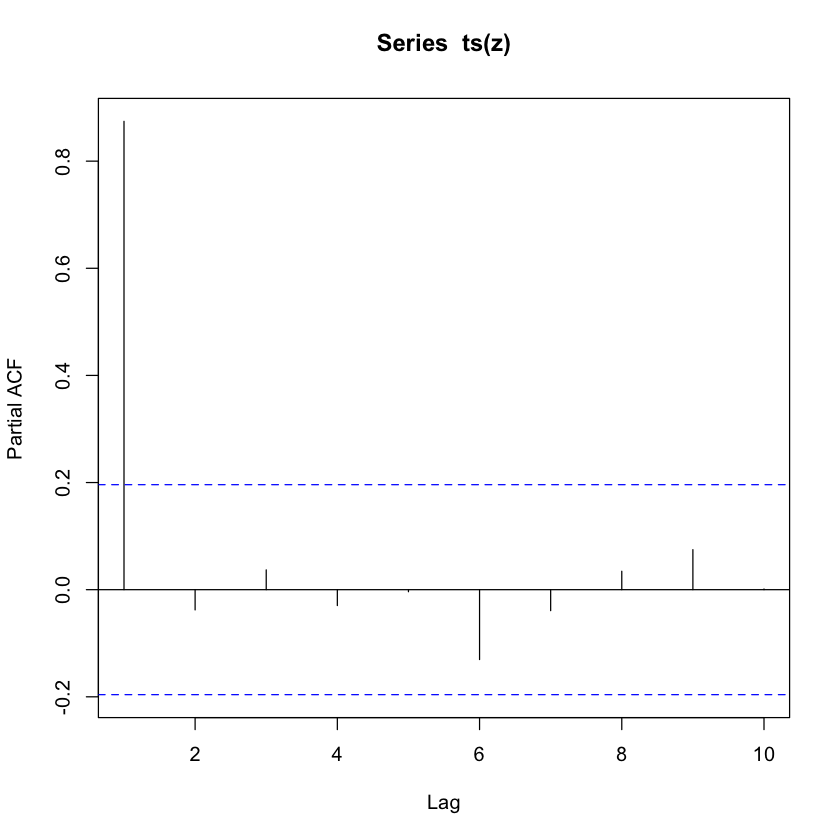

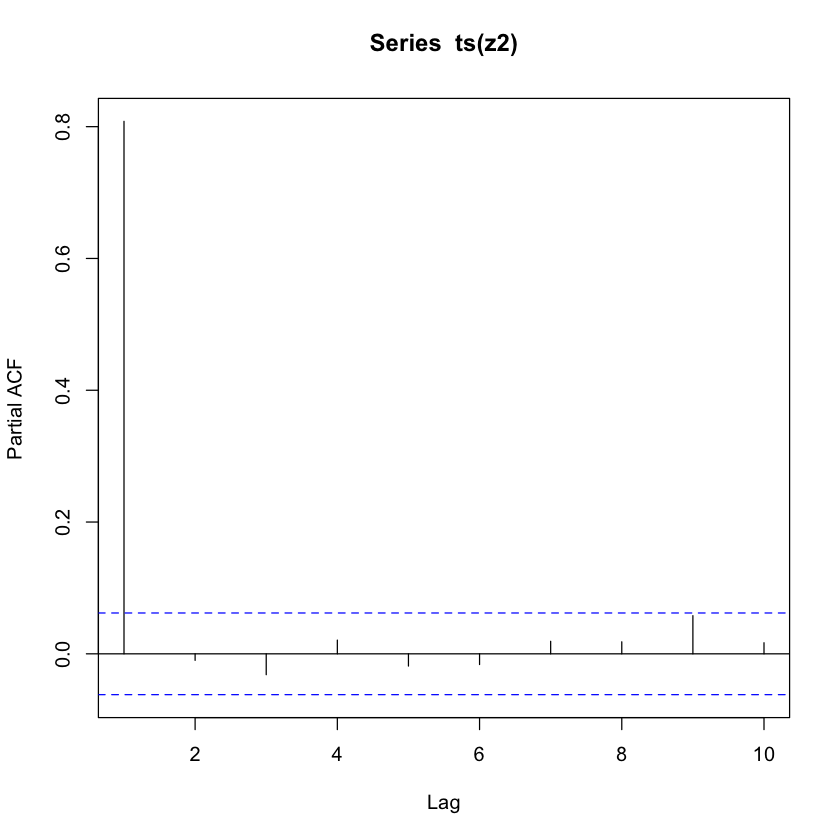

In [375]:
acf(ts(z),lag = 10)
acf(ts(z2),lag = 10)
pacf(ts(z),lag = 10)
pacf(ts(z2),lag = 10)

- n이 증가함에 따라 유의수준은 작아진다.

In [391]:
et3 <- rnorm(10000)
z3 = rep(0,10001)
for(i in 1:10000){
    z3[1] = 5
    z3[i+1] = 5 + 0.8*z3[i] + et3[i]
    }


Autocorrelations of series ‘ts(z)’, by lag

    1     2     3     4     5     6     7     8     9    10 
0.874 0.756 0.661 0.572 0.494 0.396 0.303 0.237 0.201 0.169 

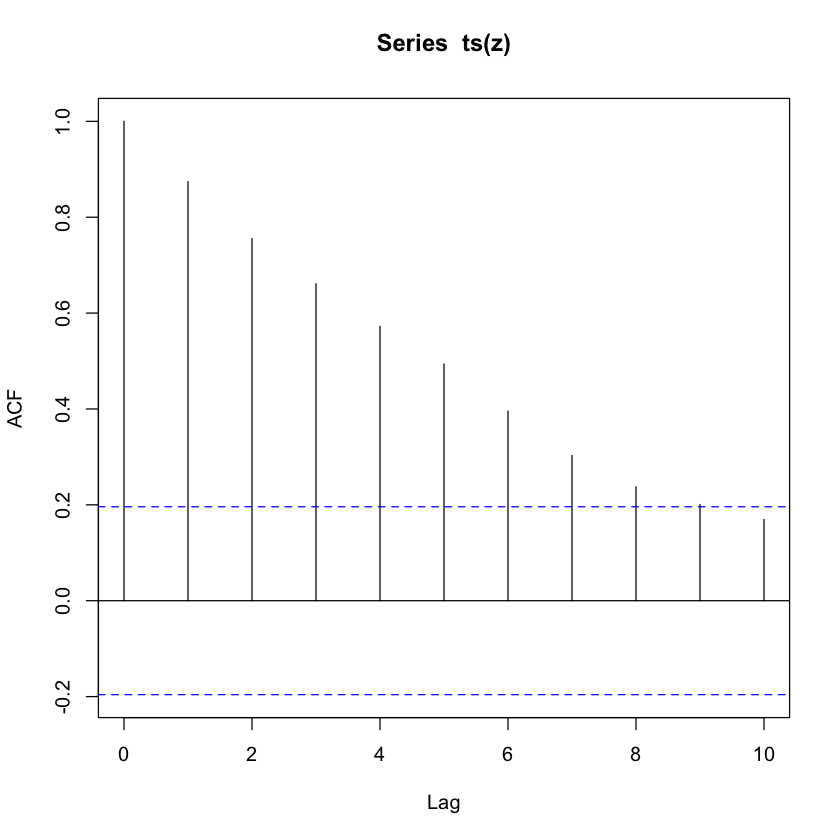


Autocorrelations of series ‘ts(z2)’, by lag

    1     2     3     4     5     6     7     8     9    10 
0.808 0.650 0.511 0.409 0.321 0.246 0.194 0.160 0.152 0.148 

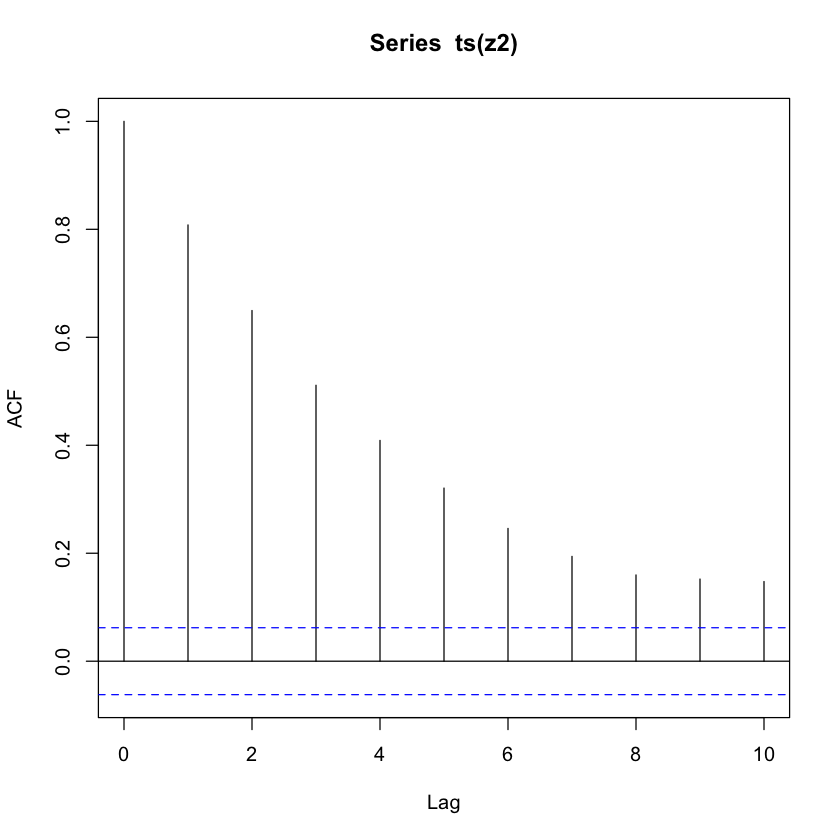


Autocorrelations of series ‘ts(z3)’, by lag

    1     2     3     4     5     6     7     8     9    10 
0.803 0.651 0.527 0.425 0.346 0.281 0.229 0.187 0.151 0.122 

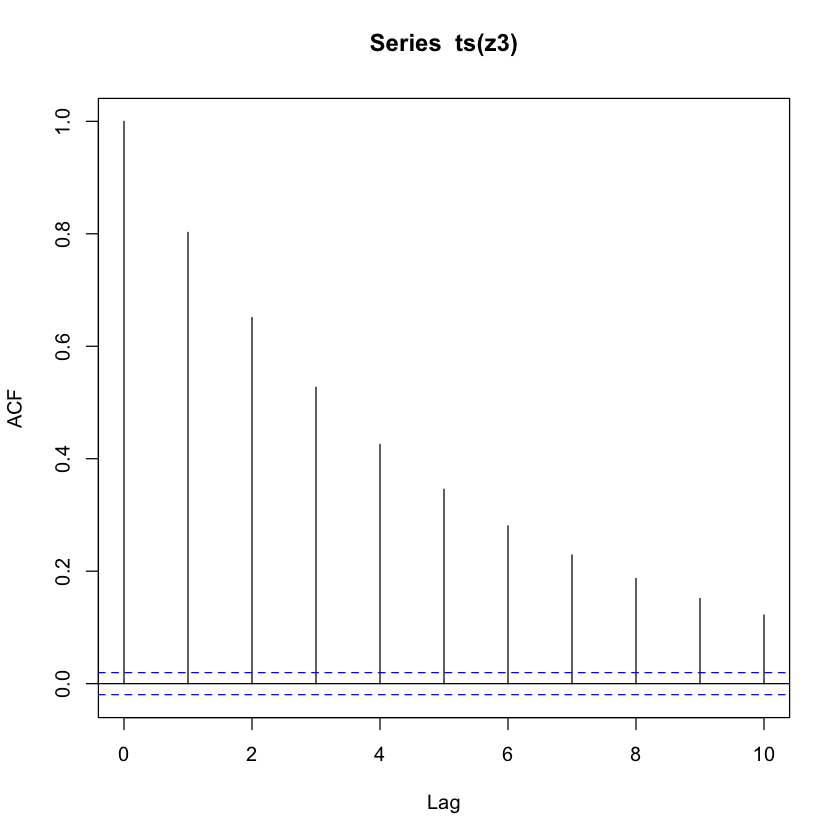

In [395]:
acf(ts(z),lag = 10)[1:10]
acf(ts(z2),lag = 10)[1:10]
acf(ts(z3),lag = 10)[1:10]

In [386]:
c(0.874,0.756, 0.661, 0.572, 0.494, 0.396, 0.303, 0.237, 0.201, 0.169 )

[1] 0.874 0.756 0.661 0.572 0.494 0.396 0.303 0.237 0.201 0.169

In [394]:
c(0.808, 0.650, 0.511, 0.409, 0.321, 0.246, 0.194, 0.160, 0.152, 0.148)

[1] 0.808 0.650 0.511 0.409 0.321 0.246 0.194 0.160 0.152 0.148